In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter, or tqdm for .py files

# Set seeds for reproducibility
torch.manual_seed(0)

# ----- Model Definition -----
class MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# ----- Normalization -----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST and split train/val
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
val_size = 6000
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# ----- Model, Optimizer, Loss -----
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MNIST_MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ----- Training/Eval Loop -----
def run_epoch(loader, model, criterion, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        loop.set_postfix(loss=loss.item())
    return total_loss / total, correct / total

# ----- Training Loop -----
for epoch in range(1, 3):
    train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc = run_epoch(val_loader, model, criterion)
    print(f"Epoch {epoch:02d}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc*100:.2f}%")

# ----- Final Test Evaluation -----
test_loss, test_acc = run_epoch(test_loader, model, criterion)
print(f"Test Accuracy: {test_acc*100:.2f}%")


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 01: Train Loss 0.2888 | Val Loss 0.1462 | Val Acc 95.65%


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 02: Train Loss 0.1052 | Val Loss 0.1414 | Val Acc 95.68%


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 96.24%


In [2]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter, or tqdm for .py files

from experiments.mnist_baseline import prepare_data, Config

# ----- Model Definition -----
class MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

SEED=0
cfg=Config()
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)

train_set, val_set, test_set = prepare_data(cfg, generator=g)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# ----- Model, Optimizer, Loss -----
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MNIST_MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ----- Training/Eval Loop -----
def run_epoch(loader, model, criterion, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        loop.set_postfix(loss=loss.item())
    return total_loss / total, correct / total

# ----- Training Loop -----
for epoch in range(1, 3):
    train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc = run_epoch(val_loader, model, criterion)
    print(f"Epoch {epoch:02d}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc*100:.2f}%")

# ----- Final Test Evaluation -----
test_loss, test_acc = run_epoch(test_loader, model, criterion)
print(f"Test Accuracy: {test_acc*100:.2f}%")


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 01: Train Loss 0.2929 | Val Loss 0.1552 | Val Acc 94.95%


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 02: Train Loss 0.1073 | Val Loss 0.0965 | Val Acc 97.07%


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 97.02%


In [ ]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from experiments.mnist_baseline import prepare_data, Config

# --- Import your BaseMLP ---
from src.models.base_mlp import BaseMLP  # Adjust path if needed

SEED = 0
cfg = Config()
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)

train_set, val_set, test_set = prepare_data(cfg, generator=g)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Instantiate your model ---
layer_dims = [784, 256, 128, 10]
model = BaseMLP(layer_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def run_epoch(loader, model, criterion, optimizer=None):
    train = optimizer is not None
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    loop = tqdm(loader, leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        if train:
            optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
        loop.set_postfix(loss=loss.item())
    return total_loss / total, correct / total

for epoch in range(1, 3):
    train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc = run_epoch(val_loader, model, criterion)
    print(f"Epoch {epoch:02d}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc*100:.2f}%")

test_loss, test_acc = run_epoch(test_loader, model, criterion)
print(f"Test Accuracy: {test_acc*100:.2f}%")


  0%|          | 0/422 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 01: Train Loss 0.2398 | Val Loss 0.1145 | Val Acc 96.45%


  0%|          | 0/422 [00:00<?, ?it/s]

In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from experiments.mnist_baseline import prepare_data, Config

# --- Import your modules ---
from src.models.base_mlp import BaseMLP
from src.training.trainers import BaseTrainer  # Update if your trainer class is named differently

SEED = 0
cfg = Config()
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)

# Prepare data
train_set, val_set, test_set = prepare_data(cfg, generator=g)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
layer_dims = [784, 256, 128, 10]
model = BaseMLP(layer_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# --- Use your custom trainer ---
trainer = BaseTrainer(
    model=model,
    optim=optimizer,
    loss_f=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    resume_if_exists=False,
    # Add any other required args as per your BaseTrainer definition
)

trainer.train(epochs=2)

test_acc = trainer.evaluate(test_loader)
print(f"Test Accuracy: {test_acc*100:.2f}%")


BaseTrainer initialized
Epoch 1/2 | Train loss: 0.2398, Val loss: 0.1146, Val acc: 96.45%
Epoch 2/2 | Train loss: 0.0947, Val loss: 0.0918, Val acc: 97.23%
Training completed
Test Accuracy: 97.35%


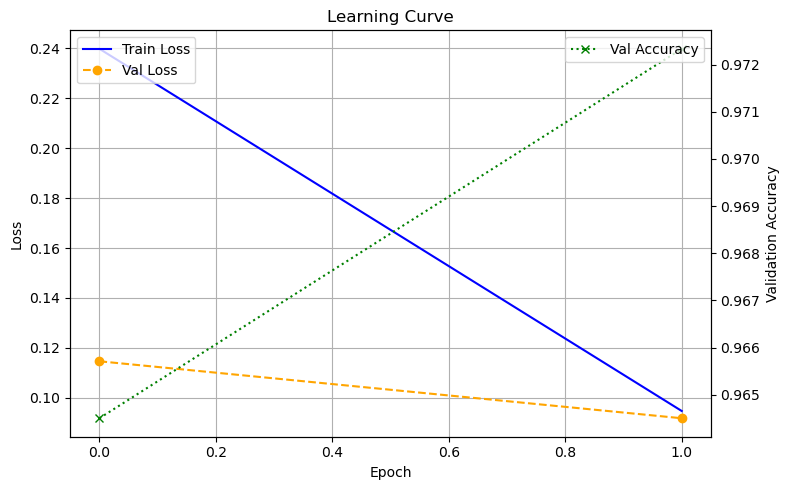

Epoch 2/2 | Train loss: 0.0947, Val loss: 0.0918, Val acc: 0.9723
Training completed
Test Accuracy: 97.35%


In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from experiments.mnist_baseline import prepare_data, Config

# --- Import your modules ---
from src.models.base_mlp import BaseMLP
from src.training.custom_trainers import NotebookFullFeaturedTrainer  # Update if your trainer class is named differently

SEED = 0
cfg = Config()
torch.manual_seed(SEED)
g = torch.Generator()
g.manual_seed(SEED)

# Prepare data
train_set, val_set, test_set = prepare_data(cfg, generator=g)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
layer_dims = [784, 256, 128, 10]
model = BaseMLP(layer_dims).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# --- Use your custom trainer ---
trainer = NotebookFullFeaturedTrainer(
    model=model,
    optim=optimizer,
    loss_f=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    resume_if_exists=False,
    # Add any other required args as per your BaseTrainer definition
)

trainer.train(epochs=2)

test_acc = trainer.evaluate(test_loader)
print(f"Test Accuracy: {test_acc*100:.2f}%")
